# **Python Web Scraping for Job Search**

####**Loading Libraries**

In [0]:
#!pip install numpy
#!pip install pandas
#!pip install bs4
#!pip install ast
#!pip install matplotlib

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import datetime
import ast
import csv
from IPython.display import HTML

%matplotlib inline

In [0]:
#We are allowed to scrap data from indeed.ca
HTML='https://www.indeed.ca/jobs?q=data+scientist&l=Toronto%2C+ON'

####**BeautifulSoup Library to Extract HTML Content on Each Search Page**
The Beautiful Soup function can be used to extract all text from the HTML indicated above. This needs to be done for each page of results.

In [0]:
url = urllib.request.urlopen(HTML)
content = url.read()
soup = BeautifulSoup(content, 'lxml')
#print(soup)

####**Extracting Hyperlinks for Each Job Posting**

We are ultimately concerned with the information on ecah job posting. Hence we need to extract the hyperlink for every job posting on each search page.

In [0]:
links = []

# This for loop searches the first 40 pages of Indeed and scrapes the job urls. 
for i in range (0, 40):
   
    url = urllib.request.urlopen('https://www.indeed.ca/jobs?q=data+scientist&start='+str(i*20)) #I multiply i by 20 because it shows 20 results per page
    content = url.read()
    soup = BeautifulSoup(content, 'lxml')
    for divTag in soup.find_all('div',{'class': 'title'}):
        for aTag in divTag.find_all('a'):
            if 'pagead' in aTag.get('href'): #check for and remove all job ads
                count = 1
            else:
                links.append('https://www.indeed.ca'+aTag.get('href'))
            
links = links[:-1]
#links       

**Beautiful Soup is run again to Extract Hyperlink Content**

Using the tags / classes from HTML format, each of the relevant attributes can be extracted for each job posting. In addition to the defined attributes, the code also runs through the text and looks for key words outlining both business and data scientist skills

In [0]:
jobResults = []
jobSpecificResults = []
techBuzzwordResults = []
businessBuzzwordResults = []

#The '.find' tool returns a value of '-1' if it is not in the text, and a large integer value if it is.
#This function simplifies this data into a simple '1' if it is in the data, and a '0' if it isn't
def searchSimplifier(val):
    if val > 0:
            val = 1
    else:
            val = 0
    return val

count = 0                
salary_list = []
for link in links:

    count = count+1

    url = urllib.request.urlopen(link)
    content = url.read()
    soup = BeautifulSoup(content, 'lxml')
    mark = "uf"
    job_data = soup.findAll('div',{'class': 'jobsearch-JobComponent icl-u-xs-mt--sm'})
    
    #Getting salary data was a bit trickier, so it required this extra code
    salary = soup.findAll('span', {'class': 'jobsearch-JobMetadataHeader-iconLabel'})
    if len(salary) == 0:
        continue
    if len(salary) > 1:
        for s in salary:
            if any(char.isdigit() for char in s.get_text()):
                salary_list.append(s.get_text())
                mark = "f"
                continue
    if mark == "uf":
        salary_list.append("NIL")
                

    for item in job_data:


        #Get Position Title
        positiontitle = item.find(class_='icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title').get_text()


        #Get Company Name
        companyname = item.find(class_='icl-u-lg-mr--sm icl-u-xs-mr--xs').get_text()
        companyname = companyname.strip('\t\n\r')

        #Get location
        joblocation = item.find(class_='jobsearch-JobMetadataHeader-iconLabel').get_text()

        #Get Days Ago Posted
        #Using try/except lets us try to access div classes that we believe to be there, but may not be
        
        try:
            daysagoposted = item.find(class_='jobsearch-JobMetadataFooter').get_text()
        except:
            daysagoposted = "NIL"
        try:
            daysagoposted = daysagoposted.replace(item.find(class_='icl-u-textColor--success').get_text(),'')
        except AttributeError:
            daysagoposted = daysagoposted
        try:
            daysagoposted = daysagoposted.replace(item.find(class_='icl-u-lg-inline icl-u-xs-hide').get_text(),'')
        except AttributeError:
            daysagoposted = daysagoposted

        try:
            daysagoposted = daysagoposted.replace('report job','')
        except AttributeError:
            daysagoposted = daysagoposted
        try:
            daysagoposted = daysagoposted.replace(item.find(class_='icl-u-lg-inline icl-us-xs-hide').get_text(),'')
        except AttributeError:
            daysagoposted = daysagoposted

        daysagoposted = daysagoposted.replace(' - ','')

        #searching for Specific Key Words

        textFind = item.find(class_='jobsearch-jobDescriptionText').get_text() #Saves the text in a 
        textFind = textFind.translate(textFind.maketrans("","", string.punctuation))
        textFindLow = textFind.lower()
        pythonFind = searchSimplifier(textFindLow.find("python"))
        hadoopFind = searchSimplifier(textFindLow.find("hadoop"))
        SASFind = searchSimplifier(textFind.find("SAS"))
        RFind = searchSimplifier(textFind.find(" R "))
        javaFind = searchSimplifier(textFindLow.find("java"))
        excelFind = searchSimplifier(textFindLow.find("excel"))
        ccplusplusFind = searchSimplifier(textFind.find(" C ") +\
                                          (textFind.find(" CC "))) # C and C++ --> C ; C/C++ --> CC
        MATLABFind = searchSimplifier(textFindLow.find("matlab"))
        SQLFind = searchSimplifier(textFind.find("SQL"))
        SPSSFind = searchSimplifier(textFind.find("SPSS"))
        tableauFind = searchSimplifier(textFindLow.find("tableau"))
        SparkFind = searchSimplifier(textFind.find("Spark")) #in case they use spark in it's literal context
        communicationFind = searchSimplifier(textFindLow.find("communication"))
        presentationFind = searchSimplifier(textFindLow.find("presentation"))
        problemsolvingFind = searchSimplifier(textFindLow.find("problem solving"))
        projectmanagementFind = searchSimplifier(textFindLow.find("project management"))
        consultingFind = searchSimplifier(textFindLow.find("consulting"))
        leadershipFind = searchSimplifier(textFindLow.find("leadership"))


        #Consolidate all of the information
        jobResults.append(((
            positiontitle, companyname, joblocation, daysagoposted, excelFind, pythonFind, RFind, javaFind,
                ccplusplusFind, MATLABFind, SASFind, SQLFind, SPSSFind, tableauFind, hadoopFind, SparkFind, 
                communicationFind, presentationFind, problemsolvingFind, projectmanagementFind,
                consultingFind, leadershipFind)))
        jobSpecificResults.append((positiontitle, companyname, joblocation, daysagoposted))
        techBuzzwordResults.append(((
            excelFind, pythonFind, RFind, javaFind,
            ccplusplusFind, MATLABFind, SASFind, SQLFind, SPSSFind, tableauFind, hadoopFind, SparkFind)))
        businessBuzzwordResults.append(((
            communicationFind, presentationFind, problemsolvingFind, projectmanagementFind,
            consultingFind, leadershipFind)))
        

####**Create a Table and Extracting CSV file**
To visualize the data in a table format, a table is created in pandas dataframe and a csv extracted.

In [15]:
# Create a table to summarize results
topJobDF = pd.DataFrame(jobResults, 
                          columns=['positiontitle', 'companyname', 'joblocation',
                                   'daysagoposted', 'excelFind', 'pythonFind', 
                                   'RFind', 'javaFind', 'ccplusplusFind', 
                                   'MATLABFind', 'SASFind', 'SQLFind', 'SPSSFind',
                                   'tableauFind', 'hadoopFind', 'SparkFind', 
                                   'communicationFind', 'presentationFind', 
                                   'problemsolvingFind', 
                                   'projectmanagementFind', 
                                   'consultingFind', 'leadershipFind'])
topJobDF.insert(4, "Salary", salary_list, True) 
topJobDF.head()

,positiontitle,companyname,joblocation,daysagoposted,Salary,excelFind,pythonFind,RFind,javaFind,ccplusplusFind,MATLABFind,SASFind,SQLFind,SPSSFind,tableauFind,hadoopFind,SparkFind,communicationFind,presentationFind,problemsolvingFind,projectmanagementFind,consultingFind,leadershipFind
0,Junior Data Scientist,Fiddlehead,"Moncton, NB",Today,NIL,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Data Scientist,Fiddlehead,"Moncton, NB",Today,NIL,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,Data Scientist,Canadian Security Intelligence Service,"Ottawa, ON",Just posted,"$89,400 - $108,820 a year",0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,Data Scientist,MSi Corp (Bell Canada),"Toronto, ON",2 days ago,NIL,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
4,Data Scientist,Compest Solutions Inc,"Toronto, ON",Today,$44 - $60 an hour,0,1,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0


In [0]:
export_csv = topJobDF.to_csv(r'BeautifulSoup_Scraping.csv')

####**Creating Visuals Outlining Trends in Data Science required skills**
Visualizations are created for both business skills and coding skills

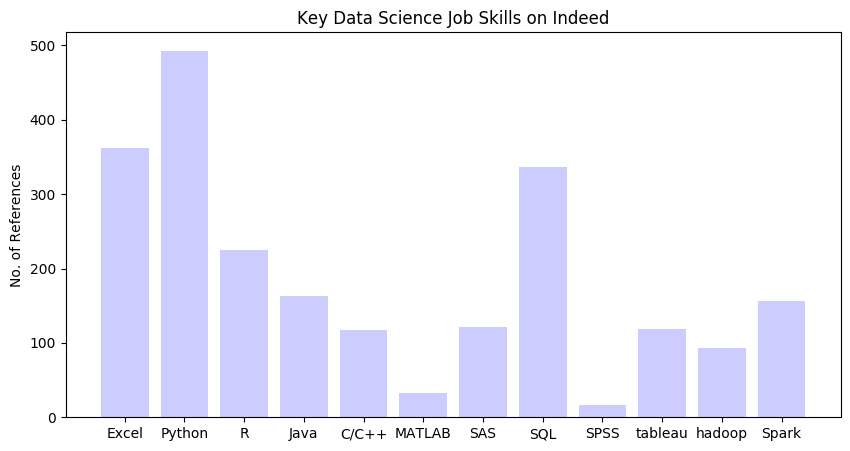

In [42]:
#Graphing tech buzzwords
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

techCumSum = []

#this function sums up the total occurrences of all specific words within the job ads.
for i in range (0 , (len(techBuzzwordResults[0]))):
    techSum = sum(n[i] for n in techBuzzwordResults)
    techCumSum.append(techSum)
    
objects = ('Excel', 'Python', 'R', 'Java', 'C/C++', 'MATLAB', 'SAS', 'SQL', 'SPSS', 'tableau', 'hadoop', 'Spark')
y_pos = np.arange(len(objects))
plt.figure(figsize=(10,5))
plt.bar(y_pos, techCumSum,  align='center', color = 'blue', alpha=0.2)
plt.xticks(y_pos, objects)
plt.ylabel('No. of References')
plt.title('Key Data Science Job Skills on Indeed')
plt.show()

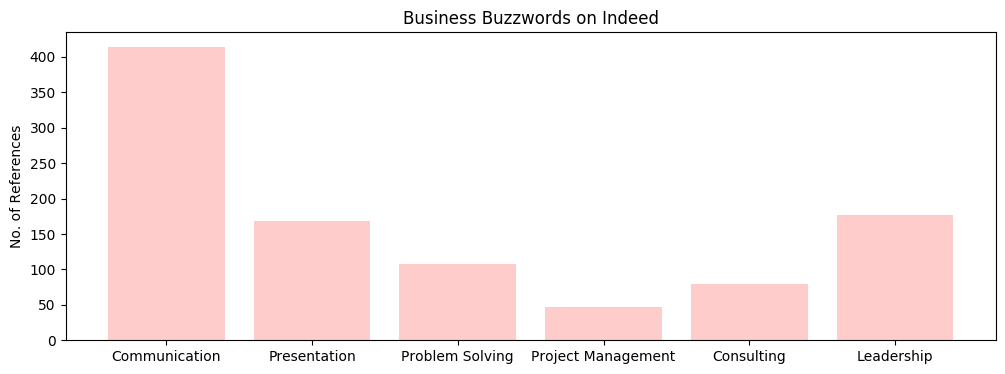

In [41]:
#Graping business buzzwords
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

businessCumSum = []

#this function sums up the total occurrences of all specific words within the job ads.
for i in range (0 , (len(businessBuzzwordResults[0]))):
    businessSum = sum(n[i] for n in businessBuzzwordResults)
    businessCumSum.append(businessSum)
    
objects = ('Communication', 'Presentation', 'Problem Solving', 
           'Project Management', 'Consulting', 'Leadership')
y_pos = np.arange(len(objects))
plt.figure(figsize=(12,4))
plt.bar(y_pos, businessCumSum,  align='center', color = 'r', alpha=0.2)
plt.xticks(y_pos, objects)
plt.ylabel('No. of References')
plt.title('Business Buzzwords on Indeed') 
plt.show()